# 一、数据准备

## 1.1 数据读取和概览

In [1]:
import pandas as pd
dataset = pd.read_csv('./data/criteo_sampled_data.csv.gz')
# download full dataset --> http://labs.criteo.com/2014/02/download-kaggle-display-advertising-challenge-dataset/
print(dataset.shape)
cols = dataset.columns.values
print(cols)
dataset.head()

(600000, 40)
['label' 'I1' 'I2' 'I3' 'I4' 'I5' 'I6' 'I7' 'I8' 'I9' 'I10' 'I11' 'I12'
 'I13' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11' 'C12'
 'C13' 'C14' 'C15' 'C16' 'C17' 'C18' 'C19' 'C20' 'C21' 'C22' 'C23' 'C24'
 'C25' 'C26']


,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,2.0,0,44.0,1.0,102.0,8.0,2.0,2.0,4.0,...,07c540c4,b04e4670,21ddcdc9,5840adea,60f6221e,NaN,3a171ecb,43f13e8b,e8b83407,731c3655
2,0,2.0,0,1.0,14.0,767.0,89.0,4.0,2.0,245.0,...,8efede7f,3412118d,NaN,NaN,e587c466,ad3062eb,3a171ecb,3b183c5c,NaN,NaN
3,0,NaN,893,NaN,NaN,4392.0,NaN,0.0,0.0,0.0,...,1e88c74f,74ef3502,NaN,NaN,6b3a5ca6,NaN,3a171ecb,9117a34a,NaN,NaN
4,0,3.0,-1,NaN,0.0,2.0,0.0,3.0,0.0,0.0,...,1e88c74f,26b3c7a7,NaN,NaN,21c9516a,NaN,32c7478e,b34f3128,NaN,NaN


In [ ]:
import base64
from IPython.core.display import display, HTML
# pip install facets_overview
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator


def display_overview(df_train, df_test=None):
    gfsg = GenericFeatureStatisticsGenerator()
    if df_test is not None:
        proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': df_train},
                                          {'name': 'test', 'table': df_test}])
    else:
        proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': df_train}])
    protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")


    # Display the facets overview visualization for this data
    HTML_TEMPLATE = """
            <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
            <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
            <facets-overview id="elem"></facets-overview>
            <script>
              document.querySelector("#elem").protoInput = "{protostr}";
            </script>"""
    html = HTML_TEMPLATE.format(protostr=protostr)
    display(HTML(html))

%time display_overview(data.iloc[:100000])

## 1.2 数据预处理

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
# 定义特征组：dense & sparse
dense_feats = [f for f in cols if f[0] == "I"]
sparse_feats = [f for f in cols if f[0] == "C"]


# 处理dense特征：缺失值填充、log处理
def process_dense_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna(0.0)
    for f in feats:
        d[f] = d[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    return d
data_dense = process_dense_feats(dataset, dense_feats)


# 处理sparse/category特征：缺失值填充、LabelEncoder
def process_sparse_feats(data, feats):
    d = data.copy()
    d = d[feats].fillna("-1")
    for f in feats:
        label_encoder = LabelEncoder()
        d[f] = label_encoder.fit_transform(d[f])
    return d
data_sparse = process_sparse_feats(dataset, sparse_feats)


total_data = pd.concat([data_dense, data_sparse], axis=1)
total_data['label'] = dataset['label']


In [4]:
# 分割 训练集和测试集
train_data, test_data = train_test_split(total_data, test_size=0.2)

# train
# train_dense_x = [train_data[f].values for f in dense_feats]
# train_sparse_x = [train_data[f].values for f in sparse_feats]
train_x = {f:train_data[f].values for f in dense_feats+sparse_feats}
train_y = train_data['label'].values

# test
# test_dense_x = [test_data[f].values for f in dense_feats]
# test_sparse_x = [test_data[f].values for f in sparse_feats]
test_x = {f:test_data[f].values for f in dense_feats+sparse_feats}
test_y = test_data['label'].values

# 二、定义模型

## 2.1 定义Input层

In [18]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers, optimizers

In [43]:
# 测试Input层
def test_Input(input_layer, X):
    y = layers.Dense(1, kernel_initializer='ones', bias_initializer='zeros')(input_layer)
    model = models.Model(input_layer, y)
    return model.predict(X)

test_input_layer = layers.Input(shape=(1,), batch_size=None, name="testInputLayer", dtype="float32")
test_Input(test_input_layer, [10.0])

array([[10.]], dtype=float32)

In [19]:
# layers.Input: 用Input而不是基本弃用的InputLayer
input_layers_dict = {}
for feat in dense_feats:
    input_layers_dict[feat] = (
        layers.Input(shape=(1,), batch_size=None, name=feat, dtype="float32")
    )
for feat in sparse_feats:
    input_layers_dict[feat] = (
        layers.Input(shape=(1,), batch_size=None, name=feat, dtype="int32")
    )

## 2.2 定义Wide部分

In [20]:
# onehot+dense：巧妙地用Embedding(voc_size, 1)的方式实现（trick）
onehotNdense_layer_dict = {}
for feat in sparse_feats:
    voc_size = total_data[feat].nunique()
    embed_size = 1
    onehotNdense_layer_dict[feat] = layers.Reshape((embed_size,), name="reshape_onehotNdense_"+feat)(
        layers.Embedding(voc_size, embed_size, name="onehotNdense_"+feat,
                     embeddings_initializer=None, embeddings_regularizer=None,
                     mask_zero=False, input_length=1)(input_layers_dict[feat])
    )
linear_sparse_added = layers.Add(name="linear_sparse_added")(list(onehotNdense_layer_dict.values()))

In [21]:
# dense: for dense_feats
dense_inputs_concat = layers.Concatenate(axis=-1, name="dense_inputs_concat")([input_layers_dict[feat] for feat in dense_feats])
linear_dense_added = layers.Dense(1, name="linear_dense_added")(dense_inputs_concat)

In [25]:
# Add Dense_added and Sparse_added
y_linear = layers.Add(name="linear_output")([linear_dense_added, linear_sparse_added])

## 2.3 定义Deep部分

In [24]:
# 测试Embedding层
voc_size = total_data['C6'].nunique()
embed_size = 4

my_first_embed_layer = layers.Embedding(voc_size, embed_size, 
                 embeddings_initializer=None, embeddings_regularizer=None,
                 mask_zero=False, input_length=1)
model = models.Sequential([my_first_embed_layer])
model.predict(total_data['C6'].values.tolist())

array([[[-0.50161713, -0.44462466,  0.3419596 ,  0.5381291 ]],

       [[-0.3324739 , -0.34545344,  0.01875949, -0.3786082 ]],

       [[-0.50161713, -0.44462466,  0.3419596 ,  0.5381291 ]],

       ...,

       [[-0.3324739 , -0.34545344,  0.01875949, -0.3786082 ]],

       [[-0.3324739 , -0.34545344,  0.01875949, -0.3786082 ]],

       [[ 0.01573586,  0.45178485,  0.12220162, -0.30380422]]],
      dtype=float32)

In [23]:
# layers.Embedding
emb_layer_dict = {}
for feat in sparse_feats:
    voc_size = total_data[feat].nunique()
    embed_size = 4  # 每个特征可以有不同的size，不同于DeepFM
    emb_layer_dict[feat] = layers.Reshape((embed_size,), name="reshape_emb_"+feat)(
        layers.Embedding(voc_size, embed_size, name="emb_"+feat,
                     embeddings_initializer=None, embeddings_regularizer=None,
                     mask_zero=False, input_length=1)(input_layers_dict[feat])
    )

In [24]:
# layers.Concatenate
to_concat = []
for feat in dense_feats:
    to_concat.append(input_layers_dict[feat])
for feat in sparse_feats:
    to_concat.append(emb_layer_dict[feat])
dnn_input_layer = layers.Concatenate(axis=-1, name='dnn_input_concat')(to_concat)

In [26]:
# dnn
x = layers.Dense(128, activation='relu', name="dnn_hidden_1")(dnn_input_layer)
x = layers.Dense(128, activation='relu', name="dnn_hidden_2")(x)
y_dnn = layers.Dense(1, name="dnn_output")(x)

In [27]:
y_added = layers.Add(name="added_output")([y_linear, y_dnn])
y = layers.Activation('sigmoid', name='y')(y_added)  # use sigmoid instead of softmax !!!

In [30]:
model = models.Model(inputs=list(input_layers_dict.values()), outputs=y, name='Wide_N_Deep')

sgd = optimizers.SGD(lr=0.1, decay=1e-6)
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['AUC'])
model.summary()

Model: "Wide_N_Deep"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C2 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C3 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C4 (InputLayer)                 [(None, 1)]          0                                            
________________________________________________________________________________________

# 三、训练模型

In [31]:
history = model.fit(train_x, train_y, batch_size=1024, epochs=5, validation_data=(test_x, test_y))

Epoch 1/5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
469/469 [==============================] - 6s 12ms/step - loss: 0.6181 - auc: 0.6206 - val_loss: 0.5667 - val_auc: 0.6533
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.5578 - auc: 0.6628 - val_loss: 0.5442 - val_auc: 0.6776
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.5400 - auc: 0.6821 - val_loss: 0.5310 - val_auc: 0.6925
Epoch 4/5
469/469 [==============================] - 4s 10ms/step - loss: 0.5289 - auc: 0.6953 - val_loss: 0.5217 - val_auc: 0.7035
Epoch 5/5
469/469 [==============================] - 4s 10ms/step - loss: 0.5215 - auc: 0.7048 - val_loss: 0.5157 - val_auc: 0.7113


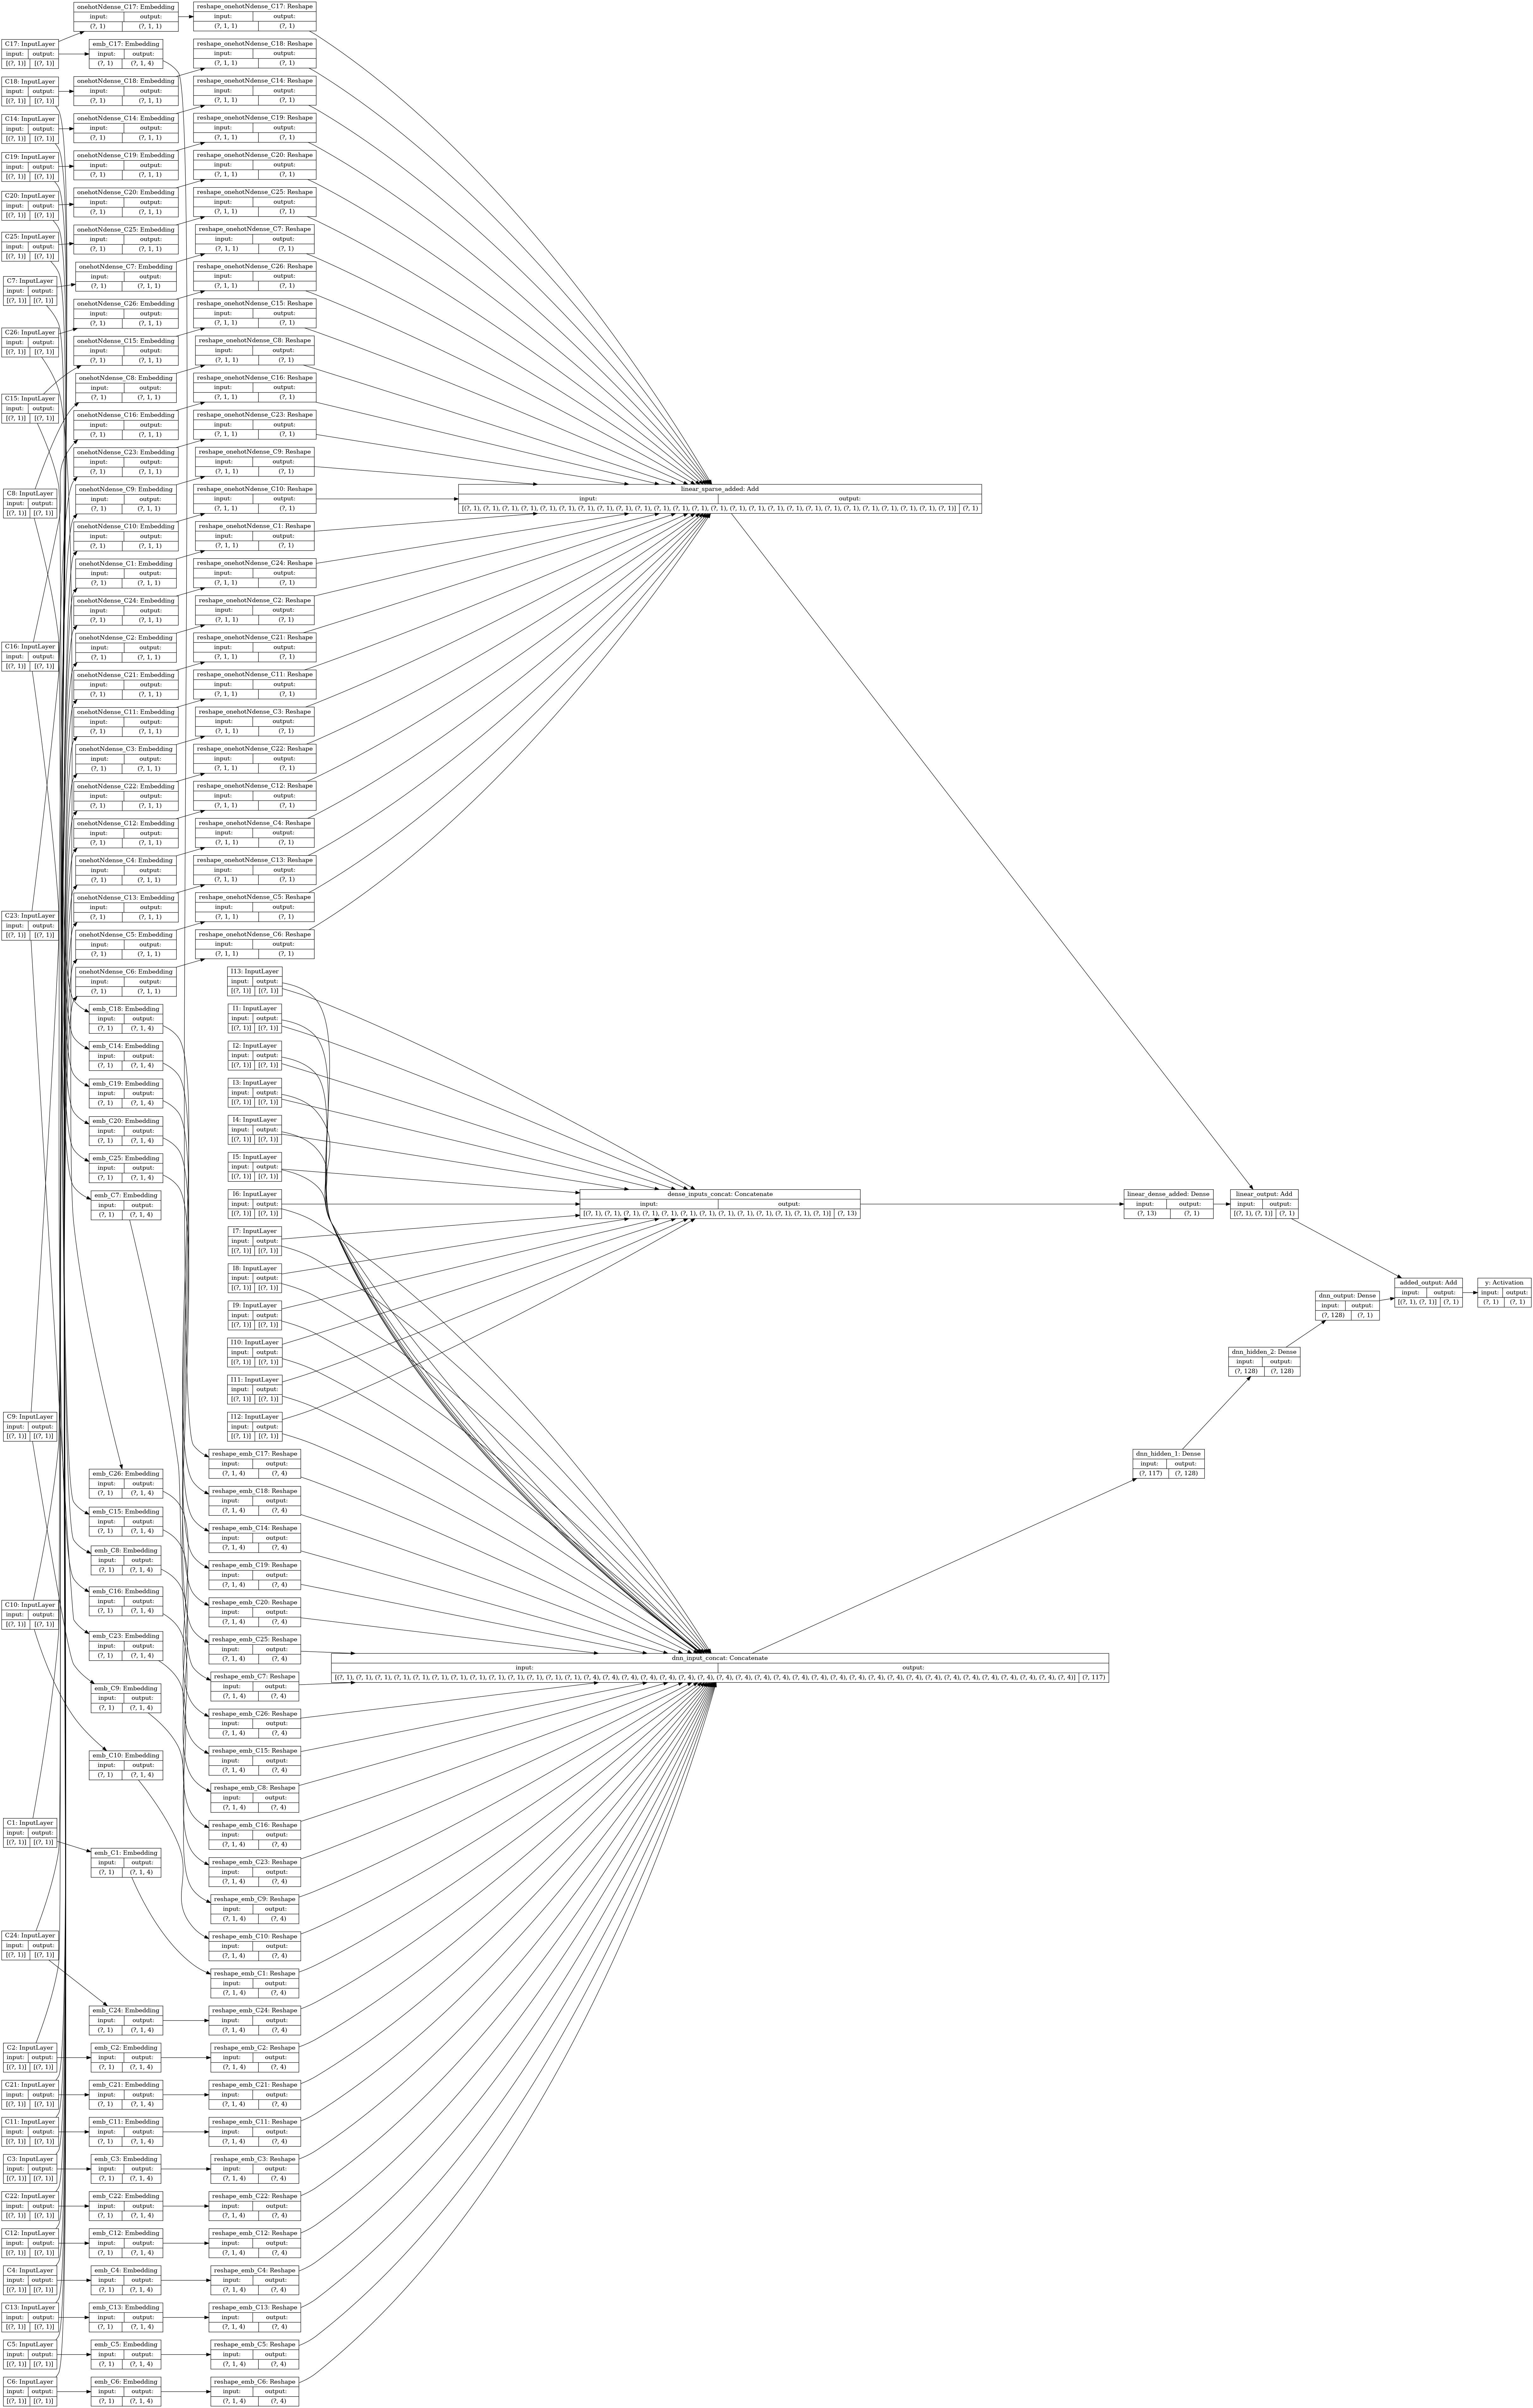

In [34]:
# pip install pydot==1.2.3
# pip install graphviz==0.8.1
# sudo apt install graphviz
from IPython.display import Image 
tf.keras.utils.plot_model(model, "wide_N_deep.png", show_shapes=True, rankdir='LR')
Image('wide_N_deep.png')